In [7]:
import torch
import torchvision
import sys, os
config_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(config_path)
import config
import sklearn as sk
import pandas as pd
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets, transforms



In [8]:
# Load MNIST as tensors
dataset = 'FashionMNIST'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Download + preprocess once
if (dataset == 'MNIST'):
    raw_train = datasets.MNIST(root=config.DATA_DIR, train=True, download=True)
    raw_test = datasets.MNIST(root=config.DATA_DIR, train=False, download=True)
if (dataset == 'FashionMNIST'):
    raw_train = datasets.FashionMNIST(root=config.DATA_DIR, train=True, download=True)
    raw_test = datasets.FashionMNIST(root=config.DATA_DIR, train=False, download=True)

X_train = raw_train.data.float().div(255.0).unsqueeze(1).to(device)   # [60000,1,28,28]
y_train = raw_train.targets.to(device)                                # [60000]
X_test  = raw_test.data.float().div(255.0).unsqueeze(1).to(device)    # [10000,1,28,28]
y_test  = raw_test.targets.to(device)



In [9]:
# Set hyperparameters

learning_rate = .005
total_epochs = 300
batch_size = 1024
dropout_probability = 0.2
print(f'training on device: {device}')

training on device: cuda


In [ ]:
# Create Model
class MNISTnet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # [B, 1, 28, 28] -> [B, 32, 28, 28]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # -> [B, 64, 28, 28]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # -> [B, 64, 14, 14]
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),                    
            nn.ReLU(),
            nn.MaxPool2d(2),                              # -> [B, 128, 7, 7]
            nn.Flatten(),                                # -> [B, 128*7*7]
            nn.Dropout(p=dropout_probability),
            nn.Linear(128 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_probability),
            nn.Linear(64,10)
        )

    def forward(self, x):
        return self.net(x)

model = MNISTnet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(lr=learning_rate, params=model.parameters(), weight_decay=1e-4)
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)
#

In [11]:
# Training loop

# ChatGPT code to avoid slow Dataloader
def iterate_minibatches(X, y, batch_size, shuffle=True):
    N = X.size(0)
    if shuffle:
        # permutation on device; avoids CPU<->GPU traffic
        idx = torch.randperm(N, device=X.device)
    else:
        idx = torch.arange(N, device=X.device)
    for start in range(0, N, batch_size):
        s = idx[start:start+batch_size]
        # index_select keeps everything on device, no copies to host
        yield torch.index_select(X, 0, s), torch.index_select(y, 0, s)

# Back to my work
def training_loop():
    accum_loss = torch.tensor(0.0, device=device)
    last_avg = torch.tensor(float("inf"), device=device)
    scaler = torch.amp.GradScaler("cuda")
    for epoch in range(1, total_epochs + 1):
        model.train()
        accum_loss.zero_()
        batch_count = 0


        for xb, yb in iterate_minibatches(X_train, y_train, batch_size, shuffle=True):
            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda'):
                preds = model(xb)
                loss  = criterion(preds, yb)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            with torch.no_grad():
                accum_loss += loss.detach()
                batch_count += 1
        scheduler.step()
        avg_loss = (accum_loss / max(1, batch_count))
    
        if epoch % 10 == 0:
            avg_loss_cpu = avg_loss.detach().cpu().item() 
            
            last_avg_cpu = (last_avg.detach().cpu().item()
                if torch.is_tensor(last_avg) else float(last_avg))
            if abs(last_avg_cpu - avg_loss_cpu) <= 0.0001 and avg_loss_cpu <= 0.02:  # early stop
                print(f"difference is {abs(last_avg_cpu - avg_loss_cpu):.6f}")
                print(f"Early stopping at epoch {epoch:5d} with loss {avg_loss_cpu:.6f}")
                break
            print(f"Epoch {epoch:5d} — avg batch loss: {avg_loss_cpu:.4f}")
            last_avg = avg_loss.detach()
    return accum_loss


In [12]:
import cProfile
cProfile.run('training_loop()', sort='cumtime')



Epoch    10 — avg batch loss: 0.2126
Epoch    20 — avg batch loss: 0.1397
Epoch    30 — avg batch loss: 0.1020
         2119751 function calls (2001742 primitive calls) in 13.308 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   13.308   13.308 {built-in method builtins.exec}
        1    0.000    0.000   13.308   13.308 <string>:1(<module>)
        1    0.078    0.078   13.308   13.308 3854952396.py:17(training_loop)
     2222    0.015    0.000    9.843    0.004 grad_scaler.py:363(step)
     2222    0.004    0.000    9.410    0.004 grad_scaler.py:351(_maybe_opt_step)
    64416    8.653    0.000    8.653    0.000 {method 'item' of 'torch._C.TensorBase' objects}
     2222    0.003    0.000    8.642    0.004 {built-in method builtins.sum}
     4443    0.002    0.000    8.639    0.002 grad_scaler.py:359(<genexpr>)
     2222    0.011    0.000    1.811    0.001 _tensor.py:592(backward)
     2222    

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Switch to eval+no-grad
model.eval()
with torch.no_grad():

    # Forward pass
    y_test = y_test.cpu().numpy()
    logits = model(X_test)                           # [10000, 10]
    preds = torch.argmax(logits, dim=1).cpu().numpy()

# Accuracy
accuracy = (preds == y_test).mean() * 100
print(f"Accuracy: {accuracy:.4f}%")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
print("Confusion Matrix:")
print(conf_matrix)

# Classification report
class_report = classification_report(y_test, preds)
print("\nClassification Report:")
print(class_report)


Accuracy: 93.2800%
Confusion Matrix:
[[867   0  17  14   1   1  94   0   6   0]
 [  2 987   1   7   1   0   0   0   2   0]
 [ 14   1 913   5  30   0  37   0   0   0]
 [ 13   4  11 930  19   0  23   0   0   0]
 [  0   0  33  23 909   0  35   0   0   0]
 [  0   0   0   0   0 986   0   8   0   6]
 [ 72   0  41  26  60   0 796   0   5   0]
 [  0   0   0   0   0   3   0 986   0  11]
 [  2   1   0   2   0   2   1   1 990   1]
 [  0   0   1   0   0   4   0  31   0 964]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1000
           1       0.99      0.99      0.99      1000
           2       0.90      0.91      0.91      1000
           3       0.92      0.93      0.93      1000
           4       0.89      0.91      0.90      1000
           5       0.99      0.99      0.99      1000
           6       0.81      0.80      0.80      1000
           7       0.96      0.99      0.97      1000
           8       0.

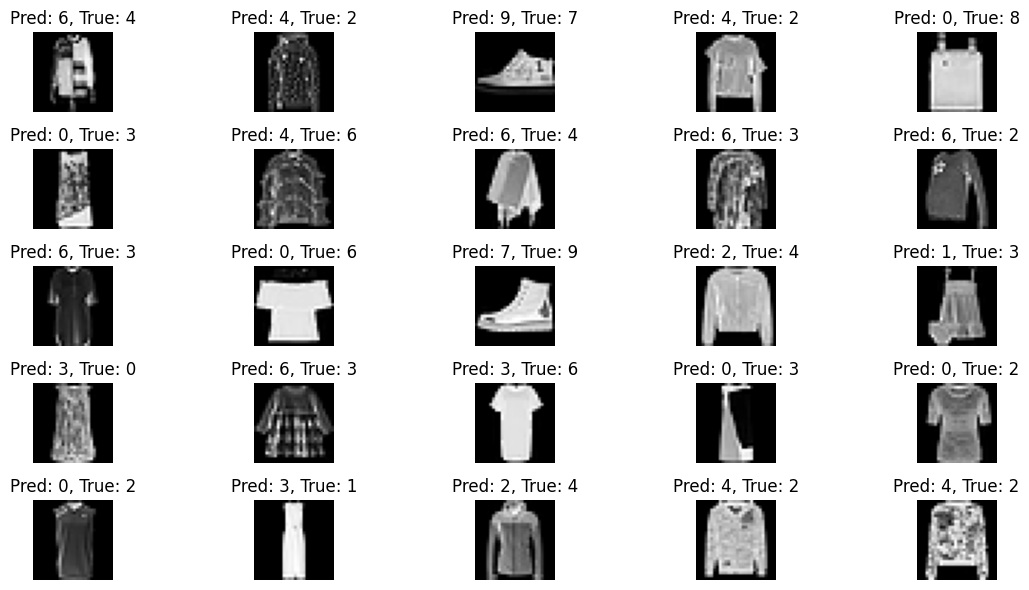

: 

In [ ]:
# Find misclassified examples
misclassified_indices = np.where(preds != y_test)[0]

# Number of images to display
num_images = 25

# Plot misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(misclassified_indices[25:25+num_images]):
    image = X_test[idx,0].view(28, 28).cpu().numpy()
    true_label = y_test[idx]
    predicted_label = preds[idx]

    plt.subplot(5, 5, i+1)
    plt.imshow(image, cmap='gray')
    plt.title(f"Pred: {predicted_label}, True: {true_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()
